In [31]:
import os

import numpy as np
import pandas as pd
from himalaya.backend import set_backend
from matplotlib import pyplot as plt
import seaborn as sns
from voxelwise_tutorials.io import load_hdf5_array
from voxelwise_tutorials.viz import plot_flatmap_from_mapper

from fmri.results import get_result_path

In [10]:
backend = set_backend("torch_cuda")

In [11]:
subject = 5
modality = 'listening'
low_level_feature = "powspec"

In [14]:
mapper_path = os.path.join("../../data", 'mappers', f"subject{subject:02}_mappers.hdf")
mapper = load_hdf5_array(mapper_path)
mapper.keys()

dict_keys(['flatmap_curvature', 'flatmap_mask', 'flatmap_rois', 'roi_mask_AC', 'roi_mask_Broca', 'roi_mask_EBA', 'roi_mask_FEF', 'roi_mask_FFA', 'roi_mask_FO', 'roi_mask_IPS', 'roi_mask_M1F', 'roi_mask_M1H', 'roi_mask_M1M', 'roi_mask_OFA', 'roi_mask_OPA', 'roi_mask_PMvh', 'roi_mask_PPA', 'roi_mask_RSC', 'roi_mask_S1F', 'roi_mask_S1H', 'roi_mask_S1M', 'roi_mask_S2F', 'roi_mask_SEF', 'roi_mask_SMFA', 'roi_mask_SMHA', 'roi_mask_V1', 'roi_mask_V2', 'roi_mask_V3', 'roi_mask_iTPJ', 'roi_mask_sPMv', 'roi_mask_sPMv2', 'voxel_to_flatmap_data', 'voxel_to_flatmap_indices', 'voxel_to_flatmap_indptr', 'voxel_to_flatmap_shape', 'voxel_to_fsaverage_data', 'voxel_to_fsaverage_indices', 'voxel_to_fsaverage_indptr', 'voxel_to_fsaverage_shape'])

# mask out early ac

In [17]:
semantic_listening_path = os.path.join(get_result_path('listening', subject), "english1000_scores.csv")
semantic_reading_path = os.path.join(get_result_path('reading', subject), "english1000_scores.csv")

semantic_listening = pd.read_csv(semantic_listening_path)
semantic_reading = pd.read_csv(semantic_reading_path)

semantic_listening_corr = semantic_listening["correlation_score"]
semantic_reading_corr = semantic_reading["correlation_score"]

KeyError: 0

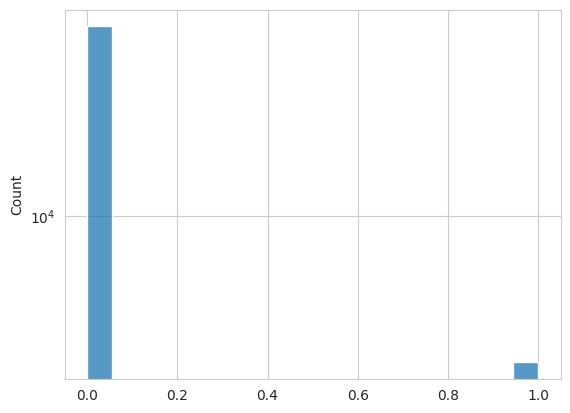

In [41]:
ac_mask = mapper["roi_mask_AC"]
ac_mask = np.bool(ac_mask)
sns.histplot(ac_mask)
plt.yscale("log")

<Axes: >

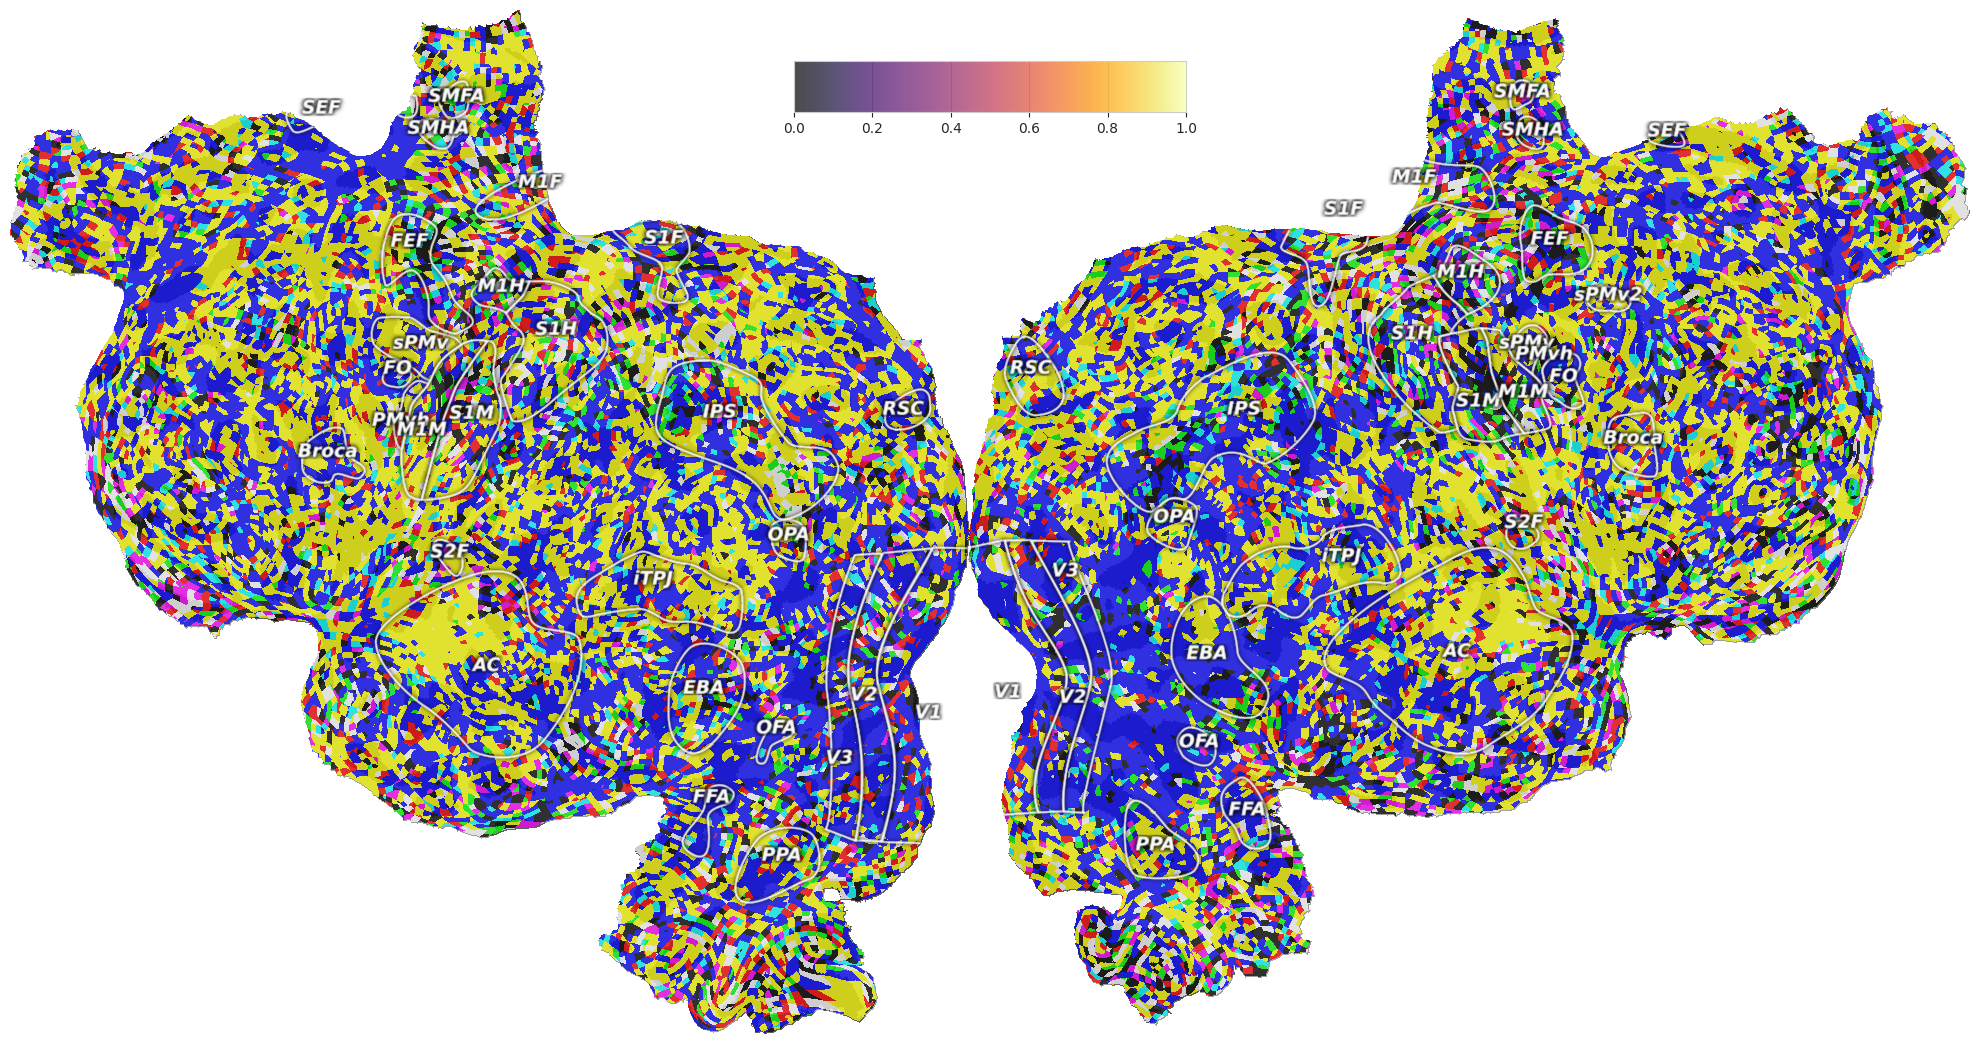

In [46]:
listening_minus_reading = semantic_listening - semantic_reading
early_ac_mask = listening_minus_reading > 0
plot_flatmap_from_mapper(early_ac_mask.astype(int), mapper_path, vmin=0, vmax=1)

In [4]:
result_path = get_result_path(modality, subject)
semantic_path = os.path.join(result_path, f"english1000_scores.csv")
vp_path = os.path.join(result_path, f"vp_english1000_{low_level_feature}_scores.csv")
rm_path = os.path.join(result_path, f"residual_{low_level_feature}_english1000_scores.csv")
rm_ridge_path = os.path.join(result_path, f"residual_ridge_{low_level_feature}_english1000_scores.csv")

In [5]:
semantic_scores = pd.read_csv(semantic_path)
vp_scores = pd.read_csv(vp_path)
rm_scores = pd.read_csv(rm_path)
rm_ridge_scores = pd.read_csv(rm_ridge_path)

In [7]:
semantic_correlation = semantic_scores["correlation_score"]
vp_correlation = vp_scores[f"semantic\\{low_level_feature}"]
residual_correlation = rm_scores["correlation_score"]
residual_ridge_correlation = rm_ridge_scores["correlation_score"]

In [ ]:
viewport_size = 450
fig, axs = plt.subplots(2, 4, figsize=(viewport_size / 100 * 4, viewport_size / 100))

vmax = max(semantic_correlation.max(), residual_correlation.max(), vp_correlation.max(),
           residual_ridge_correlation.max())

cmap = 'magma'
alpha = 1

width = flatmap_mask.shape[0]
height = flatmap_mask.shape[1]
vcenter = 2 * height / 3
hcenter = width / 2

left_ac = hcenter - 500
right_ac = hcenter + 450
vac = 650

for row, ac in enumerate([left_ac, right_ac]):
    for col, (corr, name) in enumerate(
            zip([semantic_correlation, residual_ridge_correlation, residual_correlation, vp_correlation],
                ["Semantic Feature", "Residual Method (Ridge)", "Residual Method (OLS)", "Variance Partitioning"])):
        ax = axs[row, col]

        ax.axis('off')
        ax.set_xlim([ac - viewport_size / 2, ac + viewport_size / 2])
        ax.set_ylim([vac + viewport_size / 4, vac - viewport_size / 4])

        if row == 0:
            ax.set_title(name)

        plot_flatmap_from_mapper(corr, mapper_path, ax=ax, vmin=0, vmax=vmax, with_colorbar=False, cmap=cmap,
                                 alpha=alpha)

fig.text(0, .65, "LH", rotation=90, horizontalalignment='left', weight='bold')
fig.text(0, .25, "RH", rotation=90, horizontalalignment='left', weight='bold')

cbar_ax = fig.add_axes((1, 0.05, .03, 0.89))
norm = mpl.colors.Normalize(vmin=0, vmax=vmax)

cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap='magma'), cax=cbar_ax, orientation='vertical')
cbar.set_label(r"$\rho$", fontsize=26, rotation='horizontal', loc='center')

plt.tight_layout()
plt.subplots_adjust(hspace=0)
plt.show()